# Rapport du challenge IMA205

Philippe Gratias-Quiquandon

N'hésitez pas à utiliser l'onglet Structure pour naviguer plus facilement à travers le notebook

## Segmentation

Cette première partie décrit le processus de segmentation avec le code associé.

On commence donc par sélectionner la partie de l'image qui nous intéresse s'il y a des bordures noires

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import median_filter
import json

In [2]:
path = 'img/ISIC_0000140.jpg'

image = cv2.imread(path,cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

seg_gt = cv2.imread('img/ISIC_0000140_seg.png',cv2.IMREAD_GRAYSCALE)

### Pré-processing

#### Auto-crop

In [3]:
def auto_crop(image, threshold):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    w = image.shape[0]
    h = image.shape[1]
    xs = []
    ys = []
    for i in range(w):
        if i>=5 and i<=w-5:
            # Si la médiane est plus grande qu'un seuil
            # Alors la position contient de la peau
            if np.median(gray[i,:])>=threshold:
                xs.append(i)
    for j in range(h):
        if j>=5 and j<=h-5:
            if np.median(gray[:,j])>=threshold:
                # Même chose sur l'axe y
                ys.append(j)
    if np.max(xs)-np.min(xs)>=w-10 and np.max(ys)-np.min(ys)>=h-10:
        cropped = False
        return image,cropped,None,None
    else:
        cropped = True
        # On prend le min et le max de xs qui sont les coordonnées qui contiennent de la peau
        # Même chose sur l'autre axe, on a donc bien un crop
        return image[np.min(xs):np.max(xs),np.min(ys):np.max(ys)],cropped,xs,ys

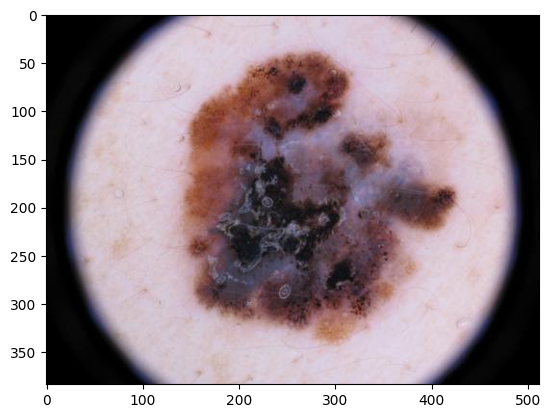

Text(0.5, 1.0, 'Cropped : True')

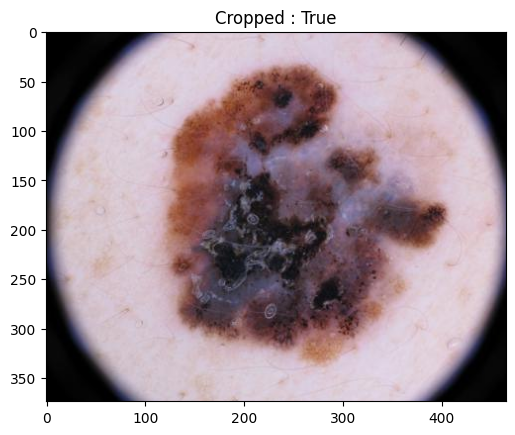

In [4]:
plt.imshow(image)
plt.show()
cropped_image,cropped,xs,ys = auto_crop(image,5)
plt.imshow(cropped_image)
plt.title("Cropped : "+str(cropped))

Cette partie est importante pour la suite car sinon, la médiane sélectionnée sera la bordure noire au lieu d'être la peau et il sera donc difficile de segmenter ce qui nous intéresse.

#### Dull Razor

Ensuite, on rase les images

On part de l'image en niveaux de gris et le filtre black top-hat va nous extraire les éléments plus petit que l'élement structurant et plus sombre que son environnement.

En somme, ça devrait nous extraire les gros poils noirs (pas trop les blonds) qui pourraient nous gêner dans la segmentation.

In [5]:
def razor(image):
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY )
    
    # On applique un filtre black top-hat
    kernel = cv2.getStructuringElement(1,(9,9)) 
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    # filtre gaussien
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
    
    # Ici, on crée un masque qui sélectionne les poils, càd les zones claires du black top-hat
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
    
    # On applique un inpainting
    dst = cv2.inpaint(image,mask,10,cv2.INPAINT_TELEA)
    
    return dst 

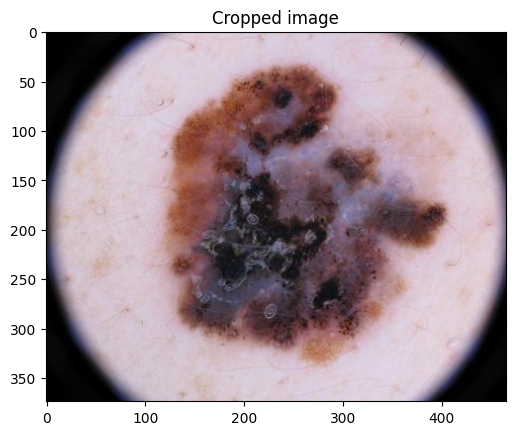

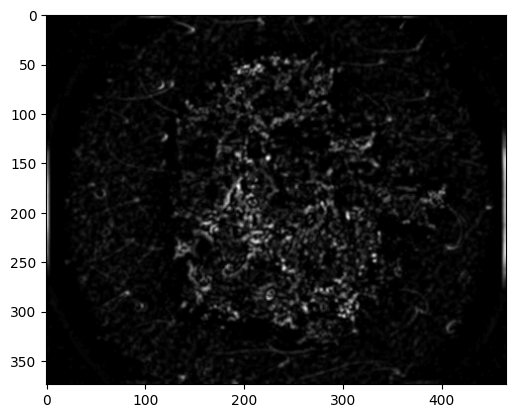

Text(0.5, 1.0, 'Shaved image')

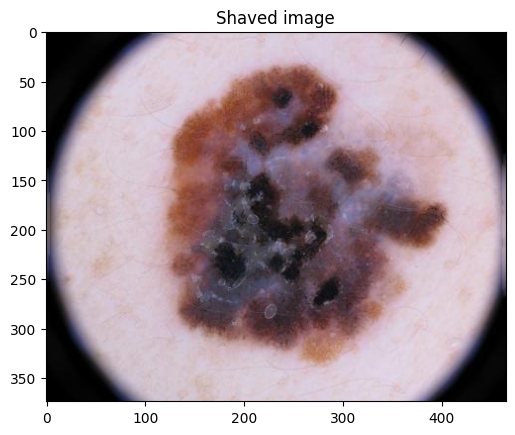

In [6]:
plt.imshow(cropped_image)
if cropped:
    plt.title("Cropped image")
plt.show()
cropped_image = razor(cropped_image)
plt.imshow(cropped_image)
plt.title("Shaved image")

### Processing

#### Conversion en image d'erreur

Ici, on va passer en coordonnées Lab et appliquer un filtre médian puis ensuite calculer la médiane de cette image filtrée.

Cela va nous permettre, si la peau est bien majoritaire sur l'image, de sélectionner des valeurs correspondant à la peau.

In [7]:
def convert_RGB_to_LAB(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2Lab)

In [8]:
def calculate_median(image,kernel_size=10):
    # image is in Lab coordinates
    L, a, b = cv2.split(image)
    
    filtered_L = median_filter(L, size=kernel_size)
    filtered_a = median_filter(a, size=kernel_size)
    filtered_b = median_filter(b, size=kernel_size)

    median_L = np.median(filtered_L)
    median_a = np.median(filtered_a)
    median_b = np.median(filtered_b)

    return median_L, median_a, median_b

Enfin, on calcule la différence entre chaque pixel de l'image en Lab et la médiane. La nouvelle image représente l'écart entre le pixel et la médiane.

In [9]:
def calculate_error(image):
    image = convert_RGB_to_LAB(image)
    tuple_median = calculate_median(image)
    w = image.shape[0]
    h = image.shape[1]
    error_image = np.zeros((w,h))
    for i in range(w):
        for j in range(h):
            # Image - la médiane
            error_tuple = image[i][j] - tuple_median
            # On prend la norme
            error_image[i][j] = np.linalg.norm(error_tuple)
    return error_image

Text(0.5, 1.0, 'Image - la médiane en coordonnées Lab')

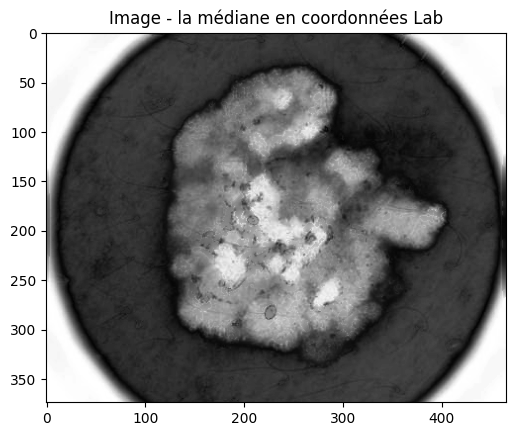

In [10]:
error_image = calculate_error(cropped_image)

plt.imshow(error_image,cmap="gray")
plt.title("Image - la médiane en coordonnées Lab")

Le résultat en niveaux de gris nous montre alors parfaitement le mélanome. Toutefois si l'on a des bordures noires, elle risque de fausser le résultat du threshold. On va donc rajouter une étape avant d'extraire la lésion.

#### Retirer les bords noirs pour la segmentation

In [11]:
def set_corners_to_zero(image):
    height, width = image.shape[:2]
    tmp_image = image.copy()

    # Définir les coordonnées des triangles dans les coins
    corners = [
        [(0, 0), (width//4, 0), (0, height//4)],               # Top left corner
        [(width-1, 0), (3*width//4, 0), (width-1, height//4)], # Top right corner
        [(0, 3*height//4), (0, height-1), (width//4, height-1)], # Bottom left corner
        [(width-1, 3*height//4),(width-1, height-1), (3*width//4, height-1)] # Bottom right corner
    ]

    for corner in corners:
        # Extrait les triangles
        pts = np.array(corner, np.int32)
        pts = pts.reshape((-1, 1, 2))

        cv2.fillPoly(tmp_image, [pts], 0)

    return tmp_image

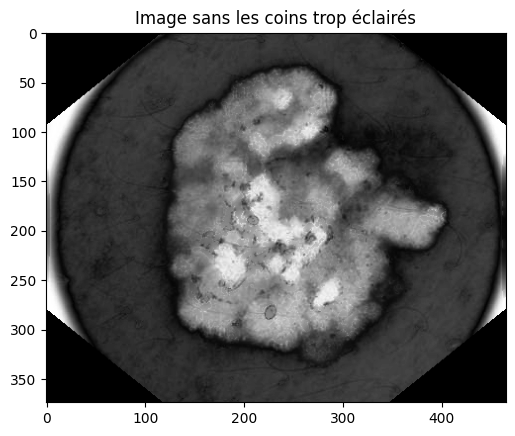

In [12]:
if cropped:
    error_image = set_corners_to_zero(error_image)
    plt.imshow(error_image,cmap="gray")
    plt.title("Image sans les coins trop éclairés")

#### Extraction par Threshold

Enfin, on va appliquer deux thresholds, et prendre une combinaison linéaire de ces deux thresholds.

On commence par un threshold d'Otsu qui minimise la variance intra-classe, ici on cherche deux classes.

Text(0.5, 1.0, 'Otsu threshold')

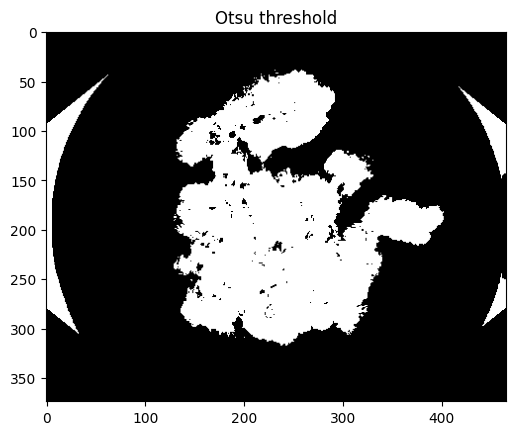

In [13]:
error_image = error_image.astype(np.uint8)

th_otsu, thresholded = cv2.threshold(error_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(thresholded, cmap="gray")
plt.title("Otsu threshold")

Après ce premier threshold, on va en faire un deuxième ne changeant rien si la lésion est déjà bien séléctionnée mais qui peut rajouter des zones si la première segmentation n'est pas bonne.

In [14]:
def get_ts(error_image,skin_pixels, beta=1):
    skin_pixels = cv2.cvtColor(skin_pixels,cv2.COLOR_RGB2GRAY)
    # On obtient les quantiles
    gamma50 = np.percentile(error_image[skin_pixels > 0], 50)
    gamma005 = np.percentile(error_image[skin_pixels > 0], 5)
    
    return gamma50 + beta * (gamma50 - gamma005)

Text(0.5, 1.0, 'Threshold adaptative')

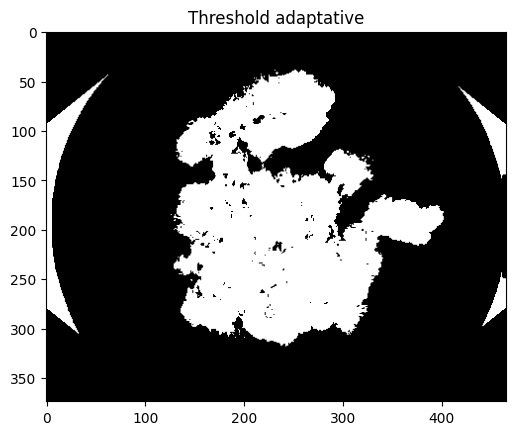

In [15]:
skin_pixels = cv2.bitwise_and(cropped_image, cropped_image, mask=np.abs(255-thresholded)) # Extrait la peau
ts = get_ts(error_image,skin_pixels)

alpha=0.5 # Compromis entre le threshold otsu et celui-ci

new_th = (alpha*ts) + ((1-alpha)*th_otsu)
thresholded = error_image>new_th

plt.imshow(thresholded,cmap="gray")
plt.title("Threshold adaptative")

Maintenant pour éviter les segmentations qui collent les bords, on va simplement prendre les composantes connexes présentes dans un carré ((h//4;3*h//4),(w//4,3*w//4)) afin de sélectionner au mieux ce qui correspond à la lésion.

In [16]:
def extract_with_connected_components(thresholded):
    thresholded_image = np.array(thresholded,dtype=np.uint8)

    num_labels, labeled_image, stats, centroids = cv2.connectedComponentsWithStats(thresholded_image, connectivity=8)

    h,w = labeled_image.shape

    # On ne regarde que les composantes présentes dans le carré central
    temp_image = labeled_image[h//4:3*h//4,w//4:3*w//4]

    h,w = temp_image.shape

    labels_in_cropped = []

    for i in range(h):
        for j in range(w):
            # On ne sélectionne pas 0 sinon on obtient l'arrière plan
            if temp_image[i][j]>0 and not (temp_image[i][j] in labels_in_cropped):
                # On rajoute le label s'il n'est pas déjà dans labels_in_cropped
                labels_in_cropped.append(temp_image[i][j])

    # A la fin, on recrée une image en ne prenant que les labels dans labels_in_cropped
    largest_component_mask = np.zeros_like(labeled_image)
    for l in labels_in_cropped:
        largest_component_mask[labeled_image == l] = 255
    
    return largest_component_mask

Text(0.5, 1.0, 'Composantes connectées qui possède au moins un pixel dans le carré central')

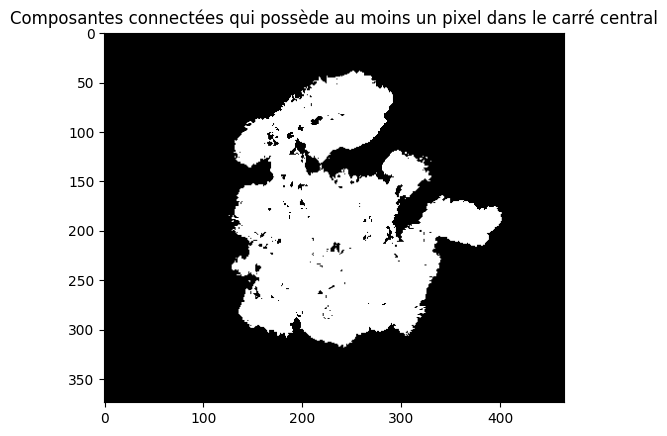

In [17]:
labels_component_mask = extract_with_connected_components(thresholded)

labels_component_mask = labels_component_mask.astype(np.uint8)

plt.imshow(labels_component_mask,cmap="gray")
plt.title("Composantes connectées qui possède au moins un pixel dans le carré central")

### Post-processing

On va simplement faire une fermeture pour avoir un maximum de lésion car, généralement, la segmentation manque les contours. Donc, il vaut mieux faire une ouverture, cela donne des meilleurs résultats par rapport aux vérités terrains.

In [18]:
def postProc(binary):

    h, w = binary.shape
    radius = int(0.01 * max(h, w))
    # Créer un disque en fonction de la taille du masque
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius + 1, 2*radius + 1))
    # Fermeture
    binary_closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    return binary_closing

On va aussi remettre le masque à la taille originale s'il y a eu du crop

In [19]:
def resize_to_original(binary,image,xs,ys):
    # Si on a crop l'image, cette fonction remet le masque à la taille d'origine
    result = np.zeros((image.shape[0],image.shape[1]))
    result[np.min(xs):np.max(xs),np.min(ys):np.max(ys)] = binary
    return result

On fait aussi un second post-processing afin de checker si les pixels que sélectionne le masque est de la peau.

On check donc la médiane des pixels dans le masque en niveaux de gris, et si la médiane est supérieure à 240, il y a de fortes chances que ce soit de la peau segmentée. Donc, on prend l'inverse du masque parce que cela arrive généralement car la lésion est majoritaire sur la photo.

On renvoie donc l'inverse du masque en ayant mis les corners à 0.

In [20]:
def secondPostProc(image,final):
    gray_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    h,w,_ = image.shape
    pix_in_mask = []
    for i in range(h):
        for j in range(w):
            if final[i][j]>0:
                pix_in_mask.append(gray_image[i][j])
                
    # Si la médiane est plus grande que 240, on inverse le masque en retirant les bords
    if np.median(pix_in_mask)>240:
        return set_corners_to_zero(np.abs(255-final))
    else:
        return final

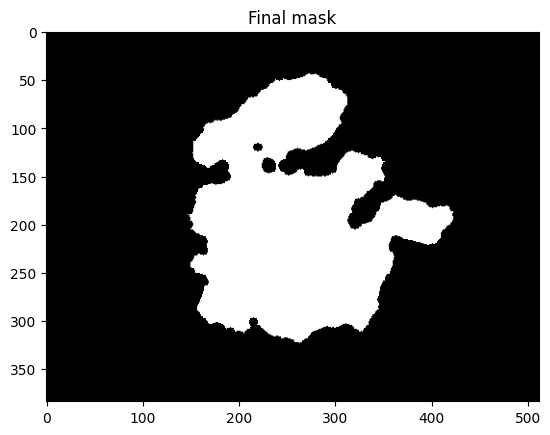

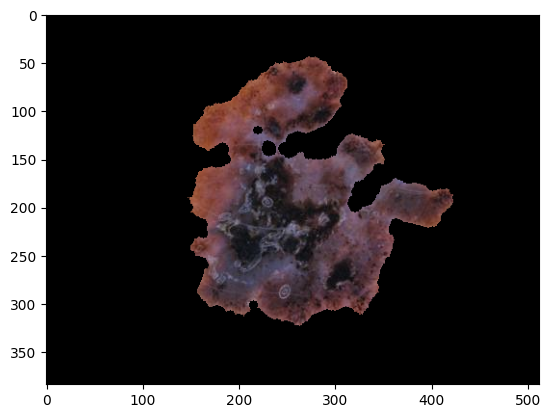

In [21]:
final = postProc(labels_component_mask)

final = secondPostProc(cropped_image,final)

if cropped:
    final = resize_to_original(final,image,xs,ys)

plt.imshow(final,cmap="gray")
plt.title("Final mask")
plt.show()

final = final.astype(np.uint8)

masked_image = cv2.bitwise_and(image, image, mask=final)

plt.imshow(masked_image)

J'utilise comme mesure le coefficient dice défini ci-dessous.

In [22]:
def dice_coefficient(seg_mask, gt_mask):
    intersection = np.sum(seg_mask & gt_mask)
    total = np.sum(seg_mask) + np.sum(gt_mask)
    
    if total == 0:
        return 1.0  # Handle division by zero
    
    dice = (2.0 * intersection) / total
    return dice

In [23]:
print("Score dice:",dice_coefficient(final,seg_gt))

Score dice: 0.7704797180667434


#### Résultats

On représente ensuite les scores dices fait sur les vérités terrains du dossier Test pour voir les performances de notre segmentation.

On a une bonne segmentation, sauf pour quelques cas pathologiques où on arrive pas du tout à extraire le bon masque.

Médiane des dices: 0.7714570306015163
Moyenne des dices: 0.6661065511991269


Text(0.5, 1.0, 'Histogramme des scores dices')

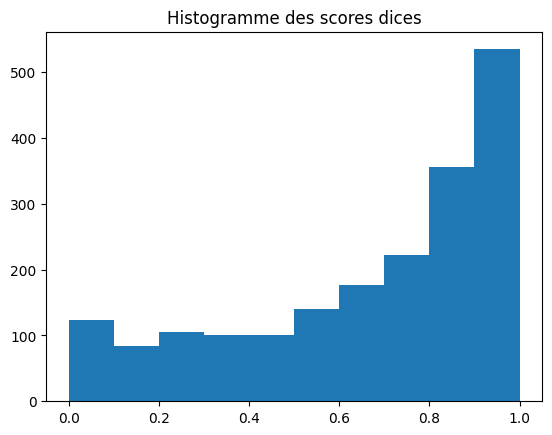

In [24]:
file_path = "dices_score.json"

with open(file_path, "r") as file:
    data = json.load(file)

values = list(data.values())

print("Médiane des dices:",np.median(values))

print("Moyenne des dices:",np.mean(values))

plt.hist(values, [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.title("Histogramme des scores dices")

## Extraction des features

J'ai choisi conformément aux articles de sélectionner 33 features avec le code suivant.

Ici, on a la segmentation qui nous permet de sélectionner la lésion et on cherche à sélectionner le reste. Cela va nous être utile car les segmentations ne sont pas parfaites et qu'il est intéressant d'extraire des informations du reste de l'image.

In [25]:
mask = final

inverted_mask = cv2.absdiff(255, mask)

Pour éviter d'extraire les zones noires qui n'ont aucun intérêt et qui engendreraient des outliers, on cherche un masque inversé cohérent.

In [26]:
black_threshold = 30

if np.median(image[0:5,0:5])<black_threshold:
    # Si cette condition est vérifiée, alors on a des bordures noires
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Ce simple threshold nous donne un masque qui exclue les bordures noires
    _, black_border_mask = cv2.threshold(gray, black_threshold, 255, cv2.THRESH_BINARY)
    
    inverted_mask = cv2.bitwise_and(black_border_mask, inverted_mask)
    

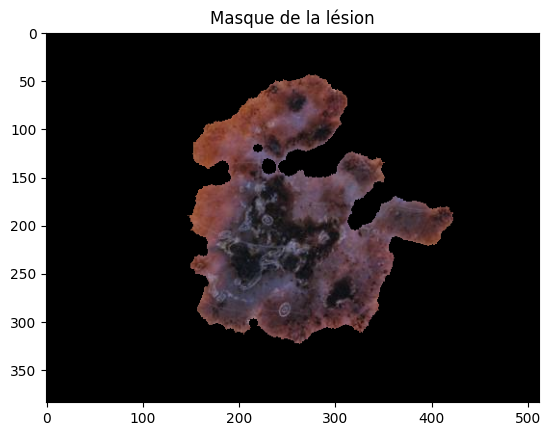

Text(0.5, 1.0, 'Masque inversé de la lésion')

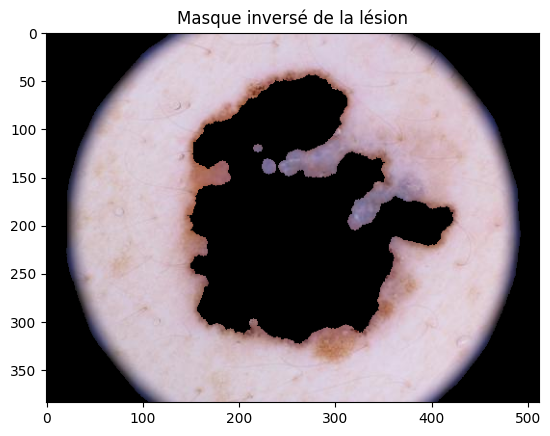

In [27]:
plt.imshow(cv2.bitwise_and(image, image, mask=mask),cmap="gray")
plt.title("Masque de la lésion")
plt.show()

plt.imshow(cv2.bitwise_and(image, image, mask=inverted_mask),cmap="gray")
plt.title("Masque inversé de la lésion")

Ensuite, on extrait les features :

D'abord, on extrait les features liées à la couleur, il y en a 15 et, d'après les articles, elles font partie des plus importantes.

Article : Automatic detection of blue-white veil and related structures in dermoscopy images

In [28]:
def return_R_G_B(image,mask):
    h,w,_ = image.shape
    R = 0
    G = 0
    B = 0
    count = 0
    for i in range(h):
        for j in range(w):
            if mask[i][j]>0:
                R+=image[i,j,0]
                G+=image[i,j,1]
                B+=image[i,j,2]
                count += 1
    R /= count
    G /= count
    B /= count
    return R, G, B

In [29]:
def f1_to_f15(image,mask,inverted_mask):
    R_L,G_L,B_L = return_R_G_B(image,mask)

    R_S,G_S,B_S = return_R_G_B(image, inverted_mask)

    sum_RGB = R_L+G_L+B_L

    f1 = R_L/sum_RGB

    f2 = G_L/sum_RGB

    f3 = B_L/sum_RGB

    f4 = R_L/R_S

    f5 = G_L/G_S

    f6 = B_L/B_S

    sum_f4_6 = f4+f5+f6

    f7 = f4/sum_f4_6

    f8 = f5/sum_f4_6

    f9 = f6/sum_f4_6

    f10 = R_L-R_S

    f11 = G_L-G_S

    f12 = B_L-B_S

    sum_f10_12 = f10+f11+f12

    f13 = f10/sum_f10_12

    f14 = f11/sum_f10_12

    f15 = f12/sum_f10_12

    return [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15]

In [30]:
def return_min_max_RGB(image,mask):
    min_values = []
    max_values = []

    for channel in range(image.shape[2]):
        # On applique le masque à chaque channel
        channel_masked_min = np.where(mask > 0, image[:, :, channel], np.inf)
        channel_masked_max = np.where(mask > 0, image[:, :, channel], 0)
        
        min_val = np.min(channel_masked_min)
        max_val = np.max(channel_masked_max)
        
        min_values.append(min_val)
        max_values.append(max_val)
    return min_values, max_values

Ici, on extrait des features de l'article Combination of features from skin pattern and ABCD analysis for lesion classification

In [31]:
def get_features(image,mask):
    binary_mask = cv2.convertScaleAbs(mask)

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    largest_contour = max(contours, key=cv2.contourArea)
    
    ellipse = cv2.fitEllipse(largest_contour)
    ((x_ellipsis,y_ellipsis),(a,b),theta) = ellipse
    elliptic_mask = np.zeros_like(binary_mask)
    cv2.ellipse(elliptic_mask, ellipse, (255, 255, 255), -1)

    difference_mask = cv2.absdiff(binary_mask, elliptic_mask)

    delta_T = cv2.countNonZero(difference_mask)
    
    T = cv2.countNonZero(mask)
    
    AS = (delta_T/T)*100 # Asymmetry
    
    perimeter = cv2.arcLength(largest_contour, True)
    BI = (perimeter**2)/(4*np.pi*T) # Border Irregularity
    
    new_image_segmented = np.zeros_like(image)
    h,w,channels = new_image_segmented.shape
    
    color_variagetion = []
    for c in range(channels):
        new_image_segmented[:,:,c] = mask/255 * image[:,:,c]
        pixel_values = []
        for i in range(h):
            for j in range(w):
                if mask[i][j]>0:
                    pixel_values.append(image[i][j][c])
        sigma_c = np.std(pixel_values)
        M_c = np.max(pixel_values)
        color_variagetion.append(sigma_c/M_c)
    
    D = 2*a # Diameter
    
    ret_array = [AS,BI]
    for c in color_variagetion:
        ret_array.append(c)
    ret_array.append(D)
    
    return ret_array

In [32]:
def extract_S2_S3(image, mask):
    h,w,_ = image.shape
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Calcule les moments du plus grand contour i.e la lésion
        M = cv2.moments(largest_contour)
        
        centroid_x = int(M['m10'] / M['m00'])
        centroid_y = int(M['m01'] / M['m00'])
        
        A1 = ((M['m20']*M['m02']) - (M['m11']**2))/(M['m00']**4)
    else:
        return 0,0
    
    P = 0
    moyenne = 0
    for i in range(h):
        for j in range(w):
            if mask[i][j]:
                moyenne += np.sqrt((i-centroid_x)**2 + (j-centroid_y)**2)
                P += 1
    moyenne /= P
    var = 0
    for i in range(h):
        for j in range(w):
            if mask[i][j]:
                var += (np.sqrt((i-centroid_x)**2 + (j-centroid_y)**2) - moyenne)**2
    var = np.sqrt(var/P)
    
    if A1<=1/(16*(np.pi**2)):
        S3 = 16*(np.pi**2)*A1
    else:
        S3 = 1/(16*(np.pi**2)*A1)
    
    return moyenne/var, S3

Quitte à extraire les features, on va également prendre les plus simples, la surface, le périmètre et les paramètres de l'ellipse associée au masque.

In [33]:
def surface(mask):
    return np.sum(mask>0)

In [34]:
def perimeter(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Ensure there's at least one contour found
    if len(contours) > 0:
        # Find the outer contour (largest perimeter)
        outer_contour = max(contours, key=cv2.contourArea)
        
        # Calculate the perimeter of the outer contour
        perimeter = cv2.arcLength(outer_contour, True)
        
        return perimeter

In [35]:
def ellipsis_features(mask):
    binary_mask = cv2.convertScaleAbs(mask)

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    outer_contour = max(contours, key=cv2.contourArea)
    
    ellipse = cv2.fitEllipse(outer_contour)
    ((x_ellipsis,y_ellipsis),(a,b),theta) = ellipse
    
    return [x_ellipsis,y_ellipsis,a,b,theta]

## Machine Learning : SVM

In [36]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

In [37]:
file_path = "features_train.csv"

df = pd.read_csv(file_path)

nb_rows, nb_cols = df.shape

In [38]:
X, y = df.iloc[:,2:nb_cols].values, df.iloc[:,1].values

y = y-1

X = np.array(X)
y = np.array(y)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42)

In [40]:
# Scaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [41]:
# Remplace les valeurs manquantes par la moyenne correspondante

imputer = SimpleImputer(strategy='mean')

X_train = imputer.fit_transform(X_train)

X_test = imputer.transform(X_test)

In [42]:
svm = SVC(kernel='rbf',C=100,gamma=0.1)

svm.fit(X_train,y_train)

SVC(C=100, gamma=0.1)

In [43]:
print("Test score:",svm.score(X_test,y_test))

Test score: 0.7015789473684211
